In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
from keras import regularizers

In [3]:
import os

In [4]:
mylist= os.listdir('data/')

In [5]:
type(mylist)

list

In [6]:
print(mylist[1])

03-01-01-01-01-01-02.wav


In [7]:
print(mylist[400][6:-16])

03


## Plotting the audio file's waveform and its spectrogram

In [8]:
data, sampling_rate = librosa.load('data/03-01-01-01-01-01-02.wav')

In [9]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


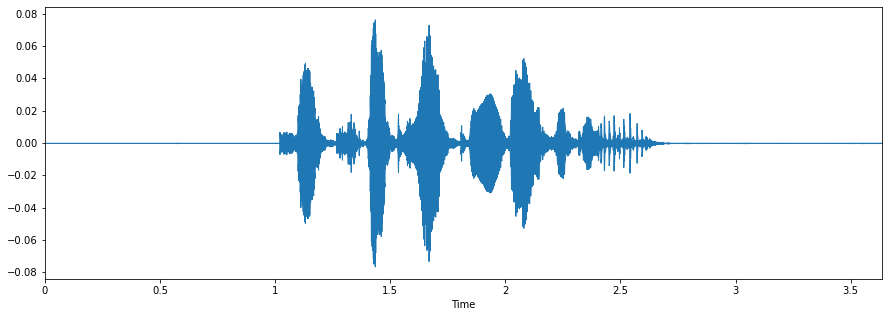

In [10]:

import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [11]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('data/03-01-01-01-01-01-02.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

C:\Users\reddyvs\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  import sys


ValueError: Incomplete wav chunk.

## Setting the labels

In [12]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[:1]=='a':
        feeling_list.append('male_angry')
    elif item[:1]=='f':
        feeling_list.append('male_fearful')
    elif item[:1]=='h':
        feeling_list.append('male_happy')
    #elif item[:1]=='n':
        #feeling_list.append('neutral')
    elif item[:2]=='sa':
        feeling_list.append('male_sad')

In [13]:
labels = pd.DataFrame(feeling_list)

In [14]:
labels[:10]

,0
0,male_calm
1,female_calm
2,male_calm
3,female_calm
4,male_calm
5,female_calm
6,male_calm
7,female_calm
8,male_calm
9,female_calm


## Getting the features of audio files using librosa

In [15]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('data/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [16]:
df

,feature
0,"[-70.26777, -70.26777, -70.26777, -70.26777, -..."
1,"[-65.70765, -65.70765, -63.11472, -61.518997, ..."
2,"[-65.4825, -65.4825, -65.4825, -65.4825, -65.4..."
3,"[-64.52845, -64.52845, -64.52845, -64.52845, -..."
4,"[-62.36431, -59.934727, -61.869602, -67.49577,..."
...,...
955,"[-31.163713, -28.617666, -24.917967, -24.49493..."
956,"[-51.8394, -51.8394, -51.8394, -51.8394, -51.8..."
957,"[-49.289055, -49.289055, -49.04858, -48.87291,..."
958,"[-57.722847, -57.722847, -57.722847, -57.72284..."


In [18]:
df3 = pd.DataFrame(df['feature'].values.tolist())

df3[:5]

In [19]:
newdf = pd.concat([df3,labels], axis=1)

In [20]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [21]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-57.447464,-58.896500,-58.750996,-57.405678,-60.078484,-63.426800,-62.638542,-61.082737,-60.234661,male_calm
1,-65.707649,-65.707649,-63.114719,-61.518997,-61.097141,-63.424599,-63.720066,-56.854614,-55.168972,-54.639999,...,-39.792141,-40.613159,-41.209202,-41.439201,-43.994278,-49.399620,-50.591599,-49.144051,-48.705654,female_calm
2,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,-65.482498,...,-31.346556,-34.310772,-35.800705,-35.936115,-37.631844,-40.119411,-41.662888,-41.323643,-40.710770,male_calm
3,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-64.528450,-65.928223,...,-48.674301,-48.596073,-47.602745,-43.049198,-42.659542,-43.188560,-44.001240,-43.610100,-44.698246,female_calm
4,-62.364311,-59.934727,-61.869602,-67.495773,-71.071808,-65.679817,-63.394402,-65.503349,-61.856644,-60.005428,...,-39.071327,-41.897121,-40.865437,-38.290604,-36.372398,-37.915779,-40.026127,-43.383774,-43.965401,male_calm


In [22]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
124,-68.377281,-71.174232,-72.227165,-70.870018,-69.319809,-64.230568,-65.108482,-64.682953,-62.713215,-59.147964,...,-36.386421,-39.448994,-40.346237,-34.800407,-32.871918,-32.259396,-32.719070,-34.919102,-36.199997,male_calm
177,-53.745876,-52.634842,-53.519768,-54.932381,-55.329754,-54.357140,-54.874832,-55.920780,-52.162537,-50.480690,...,-36.638218,-38.412392,-37.785263,-39.638126,-42.478230,-42.426834,-43.424019,-43.171604,-41.451458,female_calm
780,-61.363930,-60.424965,-60.542141,-63.737003,-64.673218,-61.401020,-62.801701,-64.522751,-64.676872,-63.780720,...,-58.870216,-61.683640,-59.392166,-58.266258,-60.922646,-64.676872,-64.676872,-64.676872,-64.178909,male_fearful
83,-53.552849,-52.381294,-49.825081,-50.466629,-54.859333,-57.549725,-59.093304,-57.289921,-57.218040,-58.383255,...,-50.852089,-52.688179,-54.263847,-53.873901,-57.603317,-59.374004,-58.332535,-57.452694,-58.009605,female_calm
12,-63.131767,-61.888165,-59.611084,-57.938656,-61.089252,-60.685398,-62.597221,-68.623726,-69.007233,-66.853775,...,-63.206009,-60.798763,-60.709068,-56.783298,-55.975407,-61.550983,-63.805748,-60.823490,-57.963692,male_calm
438,-71.805733,-71.805733,-71.805733,-71.805733,-71.805733,-71.805733,-71.805733,-71.805733,-71.805733,-71.805733,...,-48.080452,-48.708305,-47.572922,-48.468567,-48.897652,-50.247070,-49.038086,-48.715557,-51.587341,male_sad
507,-49.085495,-49.085495,-49.085495,-49.085495,-49.085495,-49.085495,-49.085495,-49.085495,-49.085495,-49.085495,...,-47.262310,-46.226849,-45.134892,-47.326176,-49.049461,-49.085495,-48.773647,-47.609108,-48.342606,female_sad
64,-49.250637,-47.740860,-49.672993,-50.764851,-51.801365,-51.357605,-51.992981,-51.296574,-49.914944,-51.691490,...,-45.861893,-46.302067,-49.884659,-48.919327,-49.577133,-49.001667,-47.466061,-47.603310,-46.976017,male_calm
749,-40.054913,-40.072048,-40.383789,-40.833176,-40.328072,-39.382156,-39.575920,-39.638176,-39.379601,-39.370834,...,-35.521240,-33.976696,-32.924881,-32.429649,-32.133648,-30.997250,-33.306576,-34.658836,-31.983351,female_angry
39,-62.610722,-62.610722,-62.610722,-62.610722,-62.610722,-62.610722,-62.610722,-62.610722,-62.610722,-62.610722,...,-40.386753,-42.516563,-41.397415,-41.803909,-41.774162,-40.359371,-41.822468,-42.906578,-44.800964,female_calm


In [23]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [24]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [25]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
917,-40.386227,-40.550884,-39.979263,-38.504513,-39.087074,-39.799557,-40.708920,-40.157829,-40.237572,-41.582844,...,-38.580383,-37.227379,-37.496994,-37.820793,-38.419064,-40.801216,-40.612724,-40.212498,-38.062607,female_fearful
8,-73.030594,-72.721794,-72.499947,-73.626694,-73.626694,-73.626694,-73.626694,-73.626694,-73.626694,-73.626694,...,-56.701408,-55.808964,-56.925110,-57.031487,-58.843853,-58.682259,-57.785545,-59.132893,-62.051418,male_calm
405,-59.255074,-59.218208,-61.168941,-59.712498,-59.700230,-60.960548,-60.868977,-59.021080,-59.191807,-61.754379,...,-52.883572,-52.793884,-55.290218,-57.921272,-56.429016,-57.002102,-58.053421,-58.613388,-56.979038,female_sad
120,-69.243256,-69.243256,-69.243256,-69.243256,-68.901970,-67.983002,-68.089203,-67.897331,-65.258011,-67.170975,...,-29.354748,-30.388714,-30.094086,-30.615465,-31.126341,-31.148714,-31.413185,-31.356203,-30.060383,male_calm
490,-54.744747,-54.456314,-56.971970,-59.304497,-59.304497,-59.304497,-58.027264,-56.805405,-54.136921,-54.495789,...,-53.959877,-51.744961,-52.448994,-51.844112,-51.704891,-51.505814,-52.127766,-53.147602,-52.696941,male_sad
948,-63.898258,-59.659367,-56.782394,-54.998428,-58.540775,-63.898258,-61.179317,-58.758701,-61.959270,-63.536823,...,-56.474083,-58.214920,-58.713482,-58.827705,-57.919724,-57.178616,-57.815914,-62.274448,-63.898258,male_fearful
498,-53.145382,-51.780399,-50.108887,-50.054245,-50.522495,-49.809898,-49.573807,-50.368843,-49.523979,-49.933105,...,-25.786306,-23.449816,-23.891396,-23.845661,-23.681883,-24.520052,-24.730570,-26.018826,-24.973238,male_sad
631,-50.773075,-51.290535,-49.537144,-49.165077,-49.960850,-49.895115,-50.056541,-47.998516,-49.212078,-51.043209,...,-51.971634,-51.041477,-49.913498,-51.230728,-52.506657,-50.665371,-49.479511,-50.153622,-50.676296,female_angry
477,-52.832333,-52.688438,-52.211685,-51.576759,-51.757797,-51.686863,-52.709007,-53.476120,-54.586895,-56.060478,...,-51.755314,-52.064899,-49.577896,-49.165901,-49.457909,-51.753361,-53.608810,-53.711082,-52.081238,female_sad
446,-50.834782,-50.984879,-53.106361,-51.711849,-53.195004,-53.064438,-52.546829,-53.192570,-51.704960,-52.067913,...,-53.111538,-53.988560,-52.939934,-52.597675,-52.951694,-52.803474,-53.736084,-53.410015,-52.198318,male_sad


In [26]:
trainfeatures = train.iloc[:, :-1]

In [27]:
trainlabel = train.iloc[:, -1:]

In [28]:
testfeatures = test.iloc[:, :-1]

In [29]:
testlabel = test.iloc[:, -1:]

In [30]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


C:\Users\reddyvs\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [31]:
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [32]:
X_train.shape

(771, 216)

## Changing dimension for CNN model

In [33]:

x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [34]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 216, 256)          1536      
_________________________________________________________________
activation_1 (Activation)    (None, 216, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 216, 128)          163968    
_________________________________________________________________
activation_2 (Activation)    (None, 216, 128)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 27, 128)          

In [36]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

### Removed the whole training part for avoiding unnecessary long epochs list

In [37]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700, validation_data=(x_testcnn, y_test))

Train on 771 samples, validate on 189 samples
Epoch 1/700
771/771 [==============================] - 4s 5ms/step - loss: 2.9009 - accuracy: 0.1154 - val_loss: 2.3122 - val_accuracy: 0.1799
Epoch 2/700
771/771 [==============================] - 4s 5ms/step - loss: 2.2890 - accuracy: 0.1569 - val_loss: 2.2616 - val_accuracy: 0.1587
Epoch 3/700
771/771 [==============================] - 3s 4ms/step - loss: 2.2333 - accuracy: 0.1699 - val_loss: 2.2448 - val_accuracy: 0.1799
Epoch 4/700
771/771 [==============================] - 3s 4ms/step - loss: 2.1965 - accuracy: 0.1699 - val_loss: 2.2424 - val_accuracy: 0.1111
Epoch 5/700
771/771 [==============================] - 4s 5ms/step - loss: 2.1673 - accuracy: 0.1790 - val_loss: 2.1937 - val_accuracy: 0.2011
Epoch 6/700
771/771 [==============================] - 3s 4ms/step - loss: 2.1501 - accuracy: 0.1920 - val_loss: 2.1842 - val_accuracy: 0.2063
Epoch 7/700
771/771 [==============================] - 4s 5ms/step - loss: 2.1274 - accuracy: 0.

Epoch 114/700
771/771 [==============================] - 4s 5ms/step - loss: 1.2566 - accuracy: 0.5331 - val_loss: 1.5780 - val_accuracy: 0.4127
Epoch 115/700
771/771 [==============================] - 4s 5ms/step - loss: 1.2477 - accuracy: 0.5331 - val_loss: 1.6750 - val_accuracy: 0.4127
Epoch 116/700
771/771 [==============================] - 4s 5ms/step - loss: 1.2522 - accuracy: 0.5188 - val_loss: 1.5893 - val_accuracy: 0.4127
Epoch 117/700
771/771 [==============================] - 4s 5ms/step - loss: 1.2394 - accuracy: 0.5279 - val_loss: 1.5922 - val_accuracy: 0.4074
Epoch 118/700
771/771 [==============================] - 4s 5ms/step - loss: 1.2439 - accuracy: 0.5473 - val_loss: 1.5907 - val_accuracy: 0.3862
Epoch 119/700
771/771 [==============================] - 4s 5ms/step - loss: 1.2471 - accuracy: 0.5422 - val_loss: 1.5772 - val_accuracy: 0.4233
Epoch 120/700
771/771 [==============================] - 4s 5ms/step - loss: 1.2355 - accuracy: 0.5422 - val_loss: 1.5731 - val_ac

771/771 [==============================] - 4s 5ms/step - loss: 1.0188 - accuracy: 0.6394 - val_loss: 1.5667 - val_accuracy: 0.4550
Epoch 227/700
771/771 [==============================] - 4s 5ms/step - loss: 1.0159 - accuracy: 0.6329 - val_loss: 1.5762 - val_accuracy: 0.4286
Epoch 228/700
771/771 [==============================] - 3s 4ms/step - loss: 1.0042 - accuracy: 0.6407 - val_loss: 1.5763 - val_accuracy: 0.4339
Epoch 229/700
771/771 [==============================] - 3s 4ms/step - loss: 1.0068 - accuracy: 0.6355 - val_loss: 1.5841 - val_accuracy: 0.4286
Epoch 230/700
771/771 [==============================] - 3s 4ms/step - loss: 1.0013 - accuracy: 0.6252 - val_loss: 1.5555 - val_accuracy: 0.4497
Epoch 231/700
771/771 [==============================] - 4s 5ms/step - loss: 1.0105 - accuracy: 0.6433 - val_loss: 1.5896 - val_accuracy: 0.4286
Epoch 232/700
771/771 [==============================] - 3s 4ms/step - loss: 1.0027 - accuracy: 0.6342 - val_loss: 1.6475 - val_accuracy: 0.4339

771/771 [==============================] - 4s 5ms/step - loss: 0.8143 - accuracy: 0.7289 - val_loss: 1.5758 - val_accuracy: 0.4180
Epoch 339/700
771/771 [==============================] - 4s 5ms/step - loss: 0.8188 - accuracy: 0.7082 - val_loss: 1.5312 - val_accuracy: 0.4233
Epoch 340/700
771/771 [==============================] - 4s 5ms/step - loss: 0.8186 - accuracy: 0.7393 - val_loss: 1.7089 - val_accuracy: 0.3810
Epoch 341/700
771/771 [==============================] - 4s 5ms/step - loss: 0.8130 - accuracy: 0.7263 - val_loss: 1.6232 - val_accuracy: 0.4021
Epoch 342/700
771/771 [==============================] - 4s 5ms/step - loss: 0.8074 - accuracy: 0.7224 - val_loss: 1.6318 - val_accuracy: 0.4127
Epoch 343/700
771/771 [==============================] - 4s 5ms/step - loss: 0.8167 - accuracy: 0.7211 - val_loss: 1.7342 - val_accuracy: 0.3651
Epoch 344/700
771/771 [==============================] - 4s 5ms/step - loss: 0.8152 - accuracy: 0.7354 - val_loss: 1.6064 - val_accuracy: 0.4233

771/771 [==============================] - 4s 5ms/step - loss: 0.6352 - accuracy: 0.7912 - val_loss: 1.9038 - val_accuracy: 0.3862
Epoch 451/700
771/771 [==============================] - 4s 5ms/step - loss: 0.6300 - accuracy: 0.8042 - val_loss: 1.6766 - val_accuracy: 0.4286
Epoch 452/700
771/771 [==============================] - 4s 5ms/step - loss: 0.6377 - accuracy: 0.7886 - val_loss: 1.6969 - val_accuracy: 0.4021
Epoch 453/700
771/771 [==============================] - 4s 5ms/step - loss: 0.6331 - accuracy: 0.8080 - val_loss: 1.6797 - val_accuracy: 0.4497
Epoch 454/700
771/771 [==============================] - 4s 5ms/step - loss: 0.6274 - accuracy: 0.8042 - val_loss: 1.7598 - val_accuracy: 0.4339
Epoch 455/700
771/771 [==============================] - 4s 5ms/step - loss: 0.6258 - accuracy: 0.7977 - val_loss: 1.6898 - val_accuracy: 0.4444
Epoch 456/700
771/771 [==============================] - 4s 5ms/step - loss: 0.6206 - accuracy: 0.7990 - val_loss: 1.7102 - val_accuracy: 0.4180

771/771 [==============================] - 4s 5ms/step - loss: 0.4454 - accuracy: 0.8573 - val_loss: 1.7994 - val_accuracy: 0.4233
Epoch 563/700
771/771 [==============================] - 4s 5ms/step - loss: 0.4509 - accuracy: 0.8664 - val_loss: 1.8378 - val_accuracy: 0.4074
Epoch 564/700
771/771 [==============================] - 4s 5ms/step - loss: 0.4418 - accuracy: 0.8781 - val_loss: 1.7877 - val_accuracy: 0.4444
Epoch 565/700
771/771 [==============================] - 4s 5ms/step - loss: 0.4382 - accuracy: 0.8781 - val_loss: 1.8994 - val_accuracy: 0.4074
Epoch 566/700
771/771 [==============================] - 4s 5ms/step - loss: 0.4489 - accuracy: 0.8703 - val_loss: 1.8978 - val_accuracy: 0.4286
Epoch 567/700
771/771 [==============================] - 4s 5ms/step - loss: 0.4243 - accuracy: 0.8859 - val_loss: 1.9324 - val_accuracy: 0.4127
Epoch 568/700
771/771 [==============================] - 4s 5ms/step - loss: 0.4350 - accuracy: 0.8742 - val_loss: 1.8440 - val_accuracy: 0.4127

771/771 [==============================] - 4s 5ms/step - loss: 0.2800 - accuracy: 0.9326 - val_loss: 2.0223 - val_accuracy: 0.4021
Epoch 675/700
771/771 [==============================] - 4s 5ms/step - loss: 0.2643 - accuracy: 0.9287 - val_loss: 2.0703 - val_accuracy: 0.4180
Epoch 676/700
771/771 [==============================] - 4s 5ms/step - loss: 0.2699 - accuracy: 0.9364 - val_loss: 2.0985 - val_accuracy: 0.4021
Epoch 677/700
771/771 [==============================] - 4s 5ms/step - loss: 0.2724 - accuracy: 0.9403 - val_loss: 2.0471 - val_accuracy: 0.4074
Epoch 678/700
771/771 [==============================] - 4s 5ms/step - loss: 0.2647 - accuracy: 0.9442 - val_loss: 2.0597 - val_accuracy: 0.4180
Epoch 679/700
771/771 [==============================] - 4s 5ms/step - loss: 0.2597 - accuracy: 0.9494 - val_loss: 2.0692 - val_accuracy: 0.3810
Epoch 680/700
771/771 [==============================] - 4s 5ms/step - loss: 0.2578 - accuracy: 0.9390 - val_loss: 2.0624 - val_accuracy: 0.4127

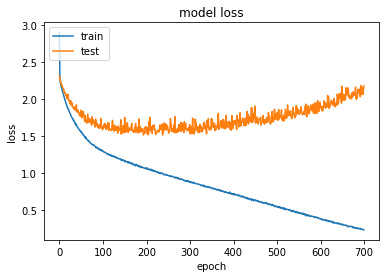

In [38]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [39]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\reddyvs\Documents\Junior-Senior Year\New folder\EmotionalyAwareDialogueSystem\saved_models\Emotion_Voice_Detection_Model.h5 


In [40]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [41]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 40.21%


## Predicting emotions on the test data

In [42]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

189/189 [==============================] - 0s 1ms/step


In [43]:
preds

array([[1.06563630e-06, 6.28070711e-06, 2.48405213e-10, ...,
        5.45231785e-07, 2.22251813e-07, 9.30338516e-04],
       [9.38392639e-01, 6.77755793e-07, 1.37657495e-02, ...,
        1.31961908e-02, 2.75255530e-04, 1.02606123e-06],
       [5.75702824e-03, 1.93552837e-01, 7.62005150e-02, ...,
        5.66844130e-04, 7.64942961e-04, 2.20513350e-04],
       ...,
       [8.22816119e-02, 6.48302019e-01, 1.35348529e-01, ...,
        1.63123715e-07, 1.37574689e-08, 2.30645105e-06],
       [7.90032744e-03, 5.14553547e-01, 3.02732699e-02, ...,
        5.98519901e-03, 3.45109473e-03, 7.71775795e-03],
       [2.37382064e-03, 1.24921925e-01, 2.95009091e-02, ...,
        4.38284304e-04, 4.62189473e-06, 2.43828428e-04]], dtype=float32)

In [44]:
preds1=preds.argmax(axis=1)

In [45]:
preds1

array([6, 0, 4, 1, 2, 8, 9, 6, 3, 1, 9, 6, 3, 9, 0, 0, 3, 6, 3, 1, 1, 1,
       0, 1, 9, 1, 1, 1, 5, 5, 5, 5, 9, 6, 1, 5, 3, 3, 0, 5, 5, 5, 1, 3,
       6, 1, 1, 7, 4, 1, 9, 1, 4, 7, 0, 5, 6, 3, 2, 6, 5, 7, 1, 7, 9, 5,
       2, 7, 1, 9, 0, 7, 1, 0, 1, 0, 0, 9, 7, 1, 2, 1, 3, 0, 1, 8, 6, 3,
       5, 0, 3, 0, 4, 6, 1, 3, 7, 3, 5, 1, 5, 3, 3, 3, 5, 3, 1, 6, 7, 0,
       8, 8, 0, 7, 5, 6, 7, 6, 7, 6, 9, 0, 6, 8, 2, 5, 3, 6, 5, 2, 8, 4,
       9, 0, 9, 6, 1, 0, 0, 0, 3, 2, 5, 5, 1, 1, 9, 5, 8, 1, 1, 9, 4, 6,
       8, 5, 9, 9, 2, 0, 9, 1, 0, 3, 7, 4, 6, 0, 7, 9, 1, 4, 1, 2, 5, 6,
       3, 5, 0, 8, 1, 5, 1, 8, 0, 0, 1, 1, 4], dtype=int64)

In [46]:
abc = preds1.astype(int).flatten()

In [47]:
predictions = (lb.inverse_transform((abc)))

In [48]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_calm
1,female_angry
2,female_sad
3,female_calm
4,female_fearful
5,male_happy
6,male_sad
7,male_calm
8,female_happy
9,female_calm


In [49]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [50]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_calm
1,female_sad
2,female_calm
3,female_calm
4,female_fearful
5,male_angry
6,male_sad
7,male_sad
8,female_angry
9,female_happy


In [51]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [52]:
finaldf[170:180]

,actualvalues,predictedvalues
170,female_fearful,female_calm
171,female_sad,female_sad
172,female_sad,female_calm
173,female_happy,female_fearful
174,female_angry,male_angry
175,male_calm,male_calm
176,female_happy,female_happy
177,male_angry,male_angry
178,female_angry,female_angry
179,male_angry,male_happy


In [53]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,20
female_calm,20
female_fearful,17
female_happy,21
female_sad,20
male_angry,17
male_calm,12
male_fearful,20
male_happy,22


In [54]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,26
female_calm,37
female_fearful,9
female_happy,21
female_sad,9
male_angry,25
male_calm,20
male_fearful,14
male_happy,10


In [55]:
finaldf.to_csv('Predictions.csv', index=False)

## Live Demo

#### Still need to finish creating a live demo recorder

In [56]:
data, sampling_rate = librosa.load('output10.wav')

Populating the interactive namespace from numpy and matplotlib


C:\Users\reddyvs\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test', 'shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


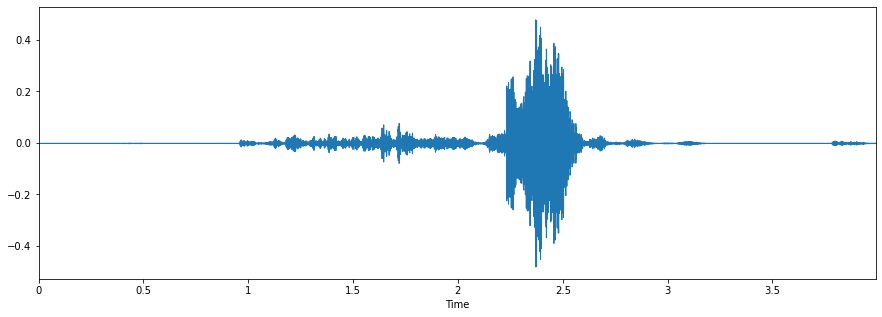

In [58]:
%pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [59]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('output10.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [60]:
livedf2= pd.DataFrame(data=livedf2)

In [61]:
livedf2 = livedf2.stack().to_frame().T

In [62]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-46.122616,-48.112896,-48.131584,-48.222752,-48.132027,-47.939976,-47.812954,-47.812202,-47.812202,-47.812202,...,-30.652212,-33.252586,-33.533241,-34.851444,-38.675488,-43.682579,-47.587387,-46.945976,-46.02813,-40.943333


In [63]:
twodim= np.expand_dims(livedf2, axis=2)

In [64]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 5ms/step


In [65]:
livepreds

array([[8.8030822e-05, 7.1494716e-17, 1.6097458e-08, 5.7713322e-12,
        3.5846604e-14, 9.9990308e-01, 1.7294879e-11, 6.9278790e-06,
        1.8540521e-06, 2.1048509e-10]], dtype=float32)

In [66]:
livepreds1=livepreds.argmax(axis=1)

In [67]:
liveabc = livepreds1.astype(int).flatten()

In [68]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['male_angry'], dtype=object)